<a href="https://colab.research.google.com/github/natiska/ai4trees-height/blob/main/notebooks/Natalia/U_net_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deployment of the U-net model

In [ ]:
!pip install wandb -qq

     |████████████████████████████████| 1.9 MB 5.1 MB/s 
     |████████████████████████████████| 182 kB 53.0 MB/s 
     |████████████████████████████████| 166 kB 57.4 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 162 kB 51.0 MB/s 
     |████████████████████████████████| 162 kB 47.0 MB/s 
     |████████████████████████████████| 158 kB 27.2 MB/s 
     |████████████████████████████████| 157 kB 43.7 MB/s 
     |████████████████████████████████| 157 kB 53.3 MB/s 
     |████████████████████████████████| 157 kB 44.7 MB/s 
     |████████████████████████████████| 157 kB 47.5 MB/s 
     |████████████████████████████████| 157 kB 26.5 MB/s 
     |████████████████████████████████| 157 kB 45.6 MB/s 
     |████████████████████████████████| 157 kB 46.5 MB/s 
     |████████████████████████████████| 156 kB 45.9 MB/s 


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import wandb
import os
import torch
from yaml import load, dump
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper
import matplotlib.pyplot as plt

In [ ]:
!git clone https://github.com/natiska/ai4trees-height.git

Cloning into 'ai4trees-height'...
remote: Enumerating objects: 324, done.
remote: Counting objects: 100% (324/324), done.
remote: Compressing objects: 100% (229/229), done.
remote: Total 324 (delta 130), reused 229 (delta 64), pack-reused 0
Receiving objects: 100% (324/324), 28.26 MiB | 37.25 MiB/s, done.
Resolving deltas: 100% (130/130), done.


In [ ]:
%cd ai4trees-height

/content/ai4trees-height


In [ ]:
!pip install -r requirements.txt -qq

     |████████████████████████████████| 97 kB 3.3 MB/s 
     |████████████████████████████████| 58 kB 5.6 MB/s 
     |████████████████████████████████| 376 kB 55.3 MB/s 


### Loading model weights from Google Drive

In [ ]:
input_type = "RGB+DSM" # choices: RGB, RGB+DSM or DSM
model_path = f"/content/drive/MyDrive/AI for Trees Share/04. End Results/subteam-RGB & Height/Google colab notebooks/U-net_approach/models/{input_type}"

In [ ]:
model_weights_path = f"{model_path}/model_weights.pth"
config_path = f"{model_path}/config.yaml"

In [ ]:
with open(config_path) as config_file:
  config = load(config_file, Loader)

In [ ]:
config

{'batch_size': 32,
 'data_dir': '/content/drive/MyDrive/AI for Trees Share/01. Data/merged_data',
 'features': [64, 128, 256, 512],
 'img_size': [256, 256],
 'input_channels': 4,
 'input_folders': ['RGB', 'DSM'],
 'learning_rate': 0.001,
 'log_in_wandb': True,
 'max_pixel_value': 255,
 'mean': [0.485, 0.456, 0.406, 0.98],
 'normalize': True,
 'num_epochs': 20,
 'output_folder': 'masks',
 'save_model': True,
 'save_output_path': '/content/drive/MyDrive/AI4Trees/run_1663561908',
 'save_predictions': False,
 'std': [0.229, 0.224, 0.225, 1.47],
 'use_pretrained': False,
 'weight_decay': 0.0001}

## 1. Pre-processing

In [ ]:
%cd models/natalia/unet_scratch

/content/ai4trees-height/models/natalia/unet_scratch


In [ ]:
from model_unet import UNET
from dataloader import *
from train import *
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np

### Recreate the data transformation that was applied for this model

In [ ]:
_, data_transform = make_train_test_transform(config["img_size"], bool(config["normalize"]), 
                                          list(config["mean"]), list(config["std"]), config["max_pixel_value"])

In [ ]:
def load_inputs(input_type, rgb_path, dsm_path):
  if input_type == "RGB":
    input = np.array(Image.open(rgb_path))
  if input_type == "DSM":
    input = np.array(Image.open(dsm_path))
  if input_type == "RGB+DSM":
    rgb = np.array(Image.open(rgb_path))
    dsm = np.array(Image.open(dsm_path))
    dsm = dsm.reshape(dsm.shape[0], dsm.shape[1], 1)
    input = np.dstack([rgb, dsm])
  return input

def preprocess_inputs(input, data_transform):
  return data_transform(image=input)["image"]

### Define data location

The DATA_PATH folder should contain two folders called RGB and DSM (if both sources are to be used).

In [ ]:
DATA_PATH = "/content/drive/MyDrive/AI for Trees Share/01. Data/merged_data/test"
tile_name = "N3_3_10.png"
rgb_path = f"{DATA_PATH}/RGB/{tile_name}"
dsm_path = f"{DATA_PATH}/DSM/{tile_name}"
input = load_inputs(input_type, rgb_path, dsm_path)

In [ ]:
def plot(rgb, dsm, input):
  #input_array = input.numpy()
  print(input.shape)
  input_array = input
  figsize = (15,15)
  if input_array.squeeze().shape == (256,256):
    fig, axes = plt.subplots(1,3, figsize=figsize)
    axes[0].imshow(rgb)
    axes[1].imshow(dsm)
    axes[2].imshow(input_array.squeeze())
  elif input_array.squeeze().shape == (4,256,256):
    fig, axes = plt.subplots(1,4,figsize=figsize)
    axes[0].imshow(rgb)
    axes[1].imshow(dsm)
    rgb_image = np.dstack([input_array[0,:,:], input_array[1,:,:], input_array[2,:,:]])
    axes[2].imshow(rgb_image)
    axes[3].imshow(input_array[-1,:,:])
  elif input_array.shape == (3,256,256):
    fig, axes = plt.subplots(1,3, figsize=figsize)
    axes[0].imshow(rgb)
    axes[1].imshow(dsm)
    rgb_image = np.dstack([input_array[0,:,:], input_array[1,:,:], input_array[2,:,:]])
    axes[2].imshow(rgb_image)
  elif input_array.squeeze().shape == (256,256,4):
    fig, axes = plt.subplots(1,4,figsize=figsize)
    axes[0].imshow(rgb)
    axes[1].imshow(dsm)
    axes[2].imshow(input_array[:,:,:-1])
    axes[3].imshow(input_array[:,:,-1])
  else:
    raise ValueError
  plt.show()

### Visualizing the input vs original RGB and DSM

In [ ]:
# Read original data
rgb = Image.open(rgb_path)
dsm = Image.open(dsm_path)

In [ ]:
transformed_input = preprocess_inputs(input, data_transform)

torch.Size([4, 256, 256])


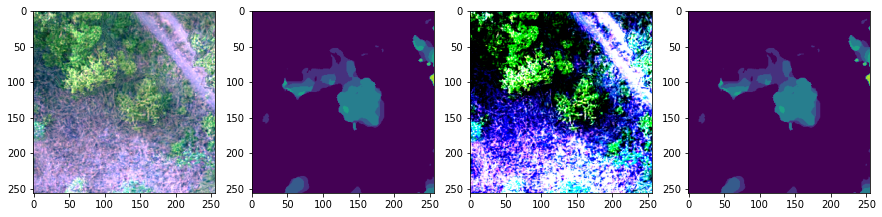

In [ ]:
# Visualize normalized input juxtaposed with the original images
plot(rgb, dsm, transformed_input)

## 2. Recreating the model

In [ ]:
model_weights = torch.load(model_weights_path, map_location=torch.device('cpu'))

In [ ]:
model = UNET(in_channels=config["input_channels"], out_channels=1, features=config["features"])
model.load_state_dict(model_weights)
model.eval()

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

## 3. Generating predictions

In [ ]:
def generate_prediction(model, input):
  with torch.no_grad():
    prediction = model(transformed_input.unsqueeze(dim=0))
    predss = torch.sigmoid(prediction)
    pred_mask = (predss>0.5).float()
    return pred_mask

In [ ]:
pred_mask = generate_prediction(model, transformed_input)

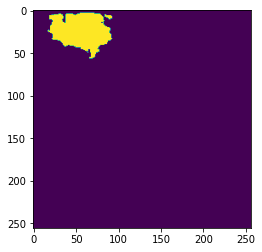

In [ ]:
plt.imshow(pred_mask.squeeze().detach().numpy())